# 🥸🕵🏻‍♂️🧳 Kafka GPT - Character-Level Text Generation

A specialized GPT model for generating Franz Kafka-style text using character-level tokenization.

**Key Features:**
- 2-character tokenization for archaic language patterns
- Enhanced architecture for Kafka's distinctive style
- Handles invented words and elevated register speech
- Optimized for fantasy literature generation

---

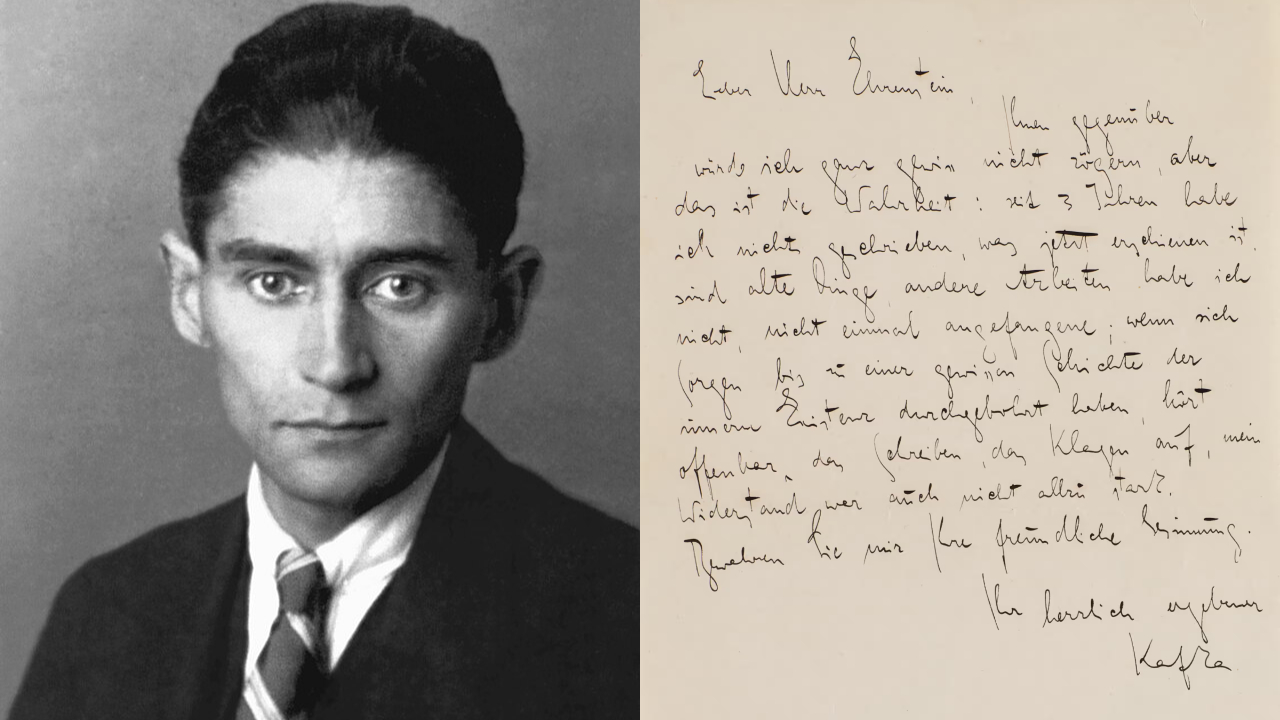

### Kafkaesque Text Generation with GPT


This notebook explores the use of GPT architecture to generate Kafkaesque completions—texts that mimic the tone, style, and themes of Franz Kafka, focusing especially on The Metamorphosis (1915).

⸻

About Franz Kafka

Franz Kafka (1883–1924) was a Prague-born writer whose works probe themes of alienation, authority, bureaucracy, and existential dread.
His unique style blends:

•	Plain, almost clinical language.

•	Surreal and dreamlike scenarios.

•	Characters trapped in absurd, oppressive systems.

Kafka’s influence spans literature, philosophy, and cultural theory, with the term “Kafkaesque” now describing nightmarishly complex or illogical situations.

⸻

Why The Metamorphosis?

The Metamorphosis is Kafka’s most iconic novella.
•	Opens with Gregor Samsa waking to find himself transformed into a giant insect.

  •	Examines guilt, shame, and estrangement in both family and society.

  •	Balances mundane detail with absurd, uncanny transformation.

Its first line—“As Gregor Samsa awoke one morning from uneasy dreams…”—

sets the stage for a narrative style ideal for testing GPT’s ability to capture Kafka’s unsettling clarity.

⸻

Research Aim

  •	Build a Kafka text corpus (with The Metamorphosis as core).

  •	Finetune GPT to generate Kafkaesque continuations from prompts.

  •	Evaluate both quantitatively (perplexity, distinct-n) and qualitatively (stylistic fidelity).
  
⸻

In [1]:
# Install required packages
%%capture
!pip install torch torchvision torchaudio
!pip install matplotlib numpy tqdm requests

print("✅ Dependencies installed successfully!")

In [2]:
# Import libraries
import numpy as np
import os, random, pickle
import tqdm
import math
from dataclasses import dataclass
import requests

import torch
import torch.nn as nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
from itertools import permutations
from torch.utils.data import DataLoader, Dataset

In [3]:
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🚀 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"📱 GPU: {torch.cuda.get_device_name(0)}")

🔥 PyTorch version: 2.8.0+cu126
🚀 CUDA available: True
📱 GPU: Tesla T4


## 📚 Data Acquisition and Preprocessing

We'll download Kafkas's text and prepare it for training.

In [6]:
# Download Kafka text data
print("📥 Downloading Kafka texts...")

#The Project Gutenberg eBook of Metamorphosis, by Franz Kafka
metamorphosis_url = "https://www.gutenberg.org/files/5200/5200-0.txt"

try:
    response = requests.get(metamorphosis_url)
    response.raise_for_status()
    with open('kafka_text.txt', 'w', encoding='utf-8') as f:
        f.write(response.text)
    print("✅ Downloaded Metamorphosis successfully!")

except Exception as e:
    print(f"⚠️ Download failed: {e}")
    print("Creating sample kafka text...")
    sample_text = '''One morning, when Gregor Samsa woke from troubled dreams, he found
himself transformed in his bed into a horrible vermin. He lay on his
armour-like back, and if he lifted his head a little he could see his
brown belly, slightly domed and divided by arches into stiff sections.
The bedding was hardly able to cover it and seemed ready to slide off
any moment. His many legs, pitifully thin compared with the size of the
rest of him, waved about helplessly as he looked.'''

    with open('kafka_text.txt', 'w', encoding='utf-8') as f:
        f.write(sample_text * 100)  # Repeat for training
    print("✅ Created sample text for demonstration")

📥 Downloading Kafka texts...
✅ Downloaded Metamorphosis successfully!


In [8]:
# Load and clean the text
with open('kafka_text.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Clean Project Gutenberg headers/footers if present
if "*** START OF" in text and "*** END OF" in text:
    start_idx = text.find("*** START OF")
    end_idx = text.find("*** END OF")
    if start_idx != -1 and end_idx != -1:
        start_line_end = text.find('\n', start_idx)
        text = text[start_line_end:end_idx].strip()

print(f"📊 Text statistics:")
print(f"   Length: {len(text):,} characters")
print(f"   Lines: {text.count(chr(10)):,}")
print(f"   Words (approx): {len(text.split()):,}")

print(f"\n📖 First 300 characters:")
print(f"'{text[:300]}...'")

📊 Text statistics:
   Length: 118,477 characters
   Lines: 1,871
   Words (approx): 21,943

📖 First 300 characters:
'Metamorphosis

by Franz Kafka

Translated by David Wyllie




I


One morning, when Gregor Samsa woke from troubled dreams, he found
himself transformed in his bed into a horrible vermin. He lay on his
armour-like back, and if he lifted his head a little he could see his
brown belly, slightly domed ...'


## 🔤 Tokenization Strategy

We use 2-character tokenization to capture Kafka's distinctive linguistic patterns while maintaining a manageable vocabulary size.

In [9]:
# Character analysis
chars = sorted(set(text))
print(f"📝 Unique characters ({len(chars)}):")
print(f"'{repr(''.join(chars))}'")

# Generate all possible 2-character combinations
print("\n🔄 Generating 2-character token combinations...")
two_char_combinations = list(permutations(chars, 2))

# Add same-character pairs (aa, bb, cc, etc.)
for char in chars:
    two_char_combinations.append((char, char))

# Convert to strings
two_char_tokens = [''.join(combo) for combo in two_char_combinations]

# Keep only tokens that exist in the text
existing_tokens = [token for token in two_char_tokens if token in text]

print(f"📈 Token statistics:")
print(f"   Possible combinations: {len(two_char_tokens):,}")
print(f"   Actually used: {len(existing_tokens):,}")
print(f"   Reduction: {(1 - len(existing_tokens)/len(two_char_tokens))*100:.1f}%")

# Show some example tokens
print(f"\n🔤 Sample tokens: {existing_tokens[:20]}")

📝 Unique characters (65):
''\n !(),-.:;?ABCDEFGHIJKLMNOPQSTUVWYabcdefghijklmnopqrstuvwxyzç—’“”''

🔄 Generating 2-character token combinations...
📈 Token statistics:
   Possible combinations: 4,225
   Actually used: 854
   Reduction: 79.8%

🔤 Sample tokens: ['\nA', '\nB', '\nC', '\nD', '\nE', '\nF', '\nG', '\nH', '\nI', '\nM', '\nN', '\nO', '\nS', '\nT', '\nU', '\nW', '\nY', '\na', '\nb', '\nc']


In [13]:
# Build vocabulary mappings
stoi = {token: idx for idx, token in enumerate(existing_tokens, 1)}
stoi["UNK"] = 0  # Unknown token
itos = {idx: token for token, idx in stoi.items()}

VOCAB_SIZE = len(stoi)
RESERVED_TOKEN = 0  # For unknown tokens

print(f"🎯 Final vocabulary size: {VOCAB_SIZE:,}")

def encode(text_str: str):
    """Encode text into 2-character tokens"""
    if len(text_str) % 2 == 1:
        text_str = text_str + ' '  # Pad with space

    # Split into 2-character chunks
    tokens = [text_str[i:i+2] for i in range(0, len(text_str), 2)]

    # Convert to token IDs
    token_ids = []
    for token in tokens:
        if token in stoi:
            token_ids.append(stoi[token])
        else:
            token_ids.append(RESERVED_TOKEN)  # UNK

    return token_ids

def decode(token_ids):
    """Decode token IDs back to text"""
    safe_ids = [tid if 0 <= tid < VOCAB_SIZE else RESERVED_TOKEN for tid in token_ids]
    return ''.join(itos[tid] for tid in safe_ids).strip()

# Test the tokenizer
test_phrase = "“What’s happened to me?” he thought. It wasn’t a dream."
encoded = encode(test_phrase)
decoded = decode(encoded)

print(f"\n🧪 Tokenizer test:")
print(f"   Original: '{test_phrase}'")
print(f"   Encoded:  {encoded[:10]}... (length: {len(encoded)})")
print(f"   Decoded:  '{decoded}'")
print(f"   Match: {'✅' if test_phrase == decoded else '❌'}")

🎯 Final vocabulary size: 855

🧪 Tokenizer test:
   Original: '“What’s happened to me?” he thought. It wasn’t a dream.'
   Encoded:  [816, 390, 682, 625, 390, 850, 327, 318, 87, 536]... (length: 28)
   Decoded:  '“What’s happened to me?” he thought. It wasn’t a dream.'
   Match: ✅


## ⚙️ Model Configuration

Configure the GPT model with parameters optimized for Kafka's writing style.

In [16]:
@dataclass
class KafkaGPTConfig:
    """Configuration optimized for Kafka's writing style"""
    block_size: int = 512      # Longer context for complex sentences
    vocab_size: int = VOCAB_SIZE
    n_layer: int = 6           # More layers for complex patterns
    n_head: int = 6            # More attention heads
    n_embd: int = 96           # Larger embeddings
    dropout: float = 0.1       # Moderate dropout
    bias: bool = True          # Use bias terms
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

config = KafkaGPTConfig()

print(f"🎛️ Model Configuration:")
print(f"   Context Length: {config.block_size}")
print(f"   Vocabulary: {config.vocab_size:,}")
print(f"   Layers: {config.n_layer}")
print(f"   Attention Heads: {config.n_head}")
print(f"   Embedding Dim: {config.n_embd}")
print(f"   Device: {config.device}")

# Estimate model size
embedding_params = config.vocab_size * config.n_embd + config.block_size * config.n_embd
transformer_params = config.n_layer * (4 * config.n_embd**2 + 4 * config.n_embd)
total_params = embedding_params + transformer_params

print(f"\n📊 Estimated parameters: {total_params/1e6:.2f}M")

🎛️ Model Configuration:
   Context Length: 512
   Vocabulary: 855
   Layers: 6
   Attention Heads: 6
   Embedding Dim: 96
   Device: cuda

📊 Estimated parameters: 0.35M


## 🏗️ Data Preparation

Prepare training and validation datasets.

In [17]:
# Encode the entire text
print("🔄 Encoding full text...")
encoded_text = encode(text)
print(f"✅ Encoded {len(encoded_text):,} tokens")

# Train/test split (90/10)
test_ratio = 0.1
split_idx = int(len(encoded_text) * (1 - test_ratio))
train_data = encoded_text[:split_idx]
test_data = encoded_text[split_idx:]

print(f"\n📊 Data split:")
print(f"   Training tokens: {len(train_data):,}")
print(f"   Test tokens: {len(test_data):,}")
print(f"   Split ratio: {len(train_data)/len(encoded_text)*100:.1f}% / {len(test_data)/len(encoded_text)*100:.1f}%")

def create_sequences(data, block_size):
    """Create input-target pairs for training"""
    sequences = []
    targets = []

    for i in range(len(data) - block_size):
        seq = data[i:i + block_size]
        target = data[i + 1:i + block_size + 1]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

print("\n🔄 Creating training sequences...")
X_train, y_train = create_sequences(train_data, config.block_size)
X_test, y_test = create_sequences(test_data, config.block_size)

print(f"📈 Sequence shapes:")
print(f"   Training: {X_train.shape}")
print(f"   Test: {X_test.shape}")

🔄 Encoding full text...
✅ Encoded 59,239 tokens

📊 Data split:
   Training tokens: 53,315
   Test tokens: 5,924
   Split ratio: 90.0% / 10.0%

🔄 Creating training sequences...
📈 Sequence shapes:
   Training: (52803, 512)
   Test: (5412, 512)


In [18]:
# Create PyTorch datasets and dataloaders
class KafkaDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.LongTensor(sequences)
        self.targets = torch.LongTensor(targets)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Create datasets
train_dataset = KafkaDataset(X_train, y_train)
test_dataset = KafkaDataset(X_test, y_test)

# Create dataloaders
batch_size = 16  # Smaller batch for longer sequences
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

print(f"🚀 DataLoaders created:")
print(f"   Batch size: {batch_size}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Test batches: {len(test_loader)}")

# Test dataloader
for batch_x, batch_y in train_loader:
    print(f"\n🧪 Sample batch shapes:")
    print(f"   Input: {batch_x.shape}")
    print(f"   Target: {batch_y.shape}")
    print(f"   Sample input tokens: {batch_x[0][:10].tolist()}")
    break

🚀 DataLoaders created:
   Batch size: 16
   Training batches: 3300
   Test batches: 338

🧪 Sample batch shapes:
   Input: torch.Size([16, 512])
   Target: torch.Size([16, 512])
   Sample input tokens: [416, 364, 76, 654, 722, 625, 428, 646, 68, 73]


## 🧠 Model Architecture

Build the GPT model with custom components optimized for literary text generation.

In [19]:
class LayerNorm(nn.Module):
    """LayerNorm with optional bias"""
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        # Key, query, value projections for all heads
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # Dropout
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout

        # Flash attention support
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("⚠️ Using slow attention. Flash Attention requires PyTorch >= 2.0")
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()

        # Calculate query, key, values for all heads
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)

        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # Causal self-attention
        if self.flash:
            y = torch.nn.functional.scaled_dot_product_attention(
                q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True
            )
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # Output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

print("✅ Model components defined")

✅ Model components defined


In [20]:
class KafkaGPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Weight tying
        self.transformer.wte.weight = self.lm_head.weight

        # Initialize weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        print(f"🧠 Model initialized with {self.get_num_params()/1e6:.2f}M parameters")

    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"

        pos = torch.arange(0, t, dtype=torch.long, device=device)

        # Forward pass
        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)

        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None, top_p=0.9):
        """Generate text with nucleus (top-p) sampling"""
        self.eval()

        for _ in range(max_new_tokens):
            # Crop context if too long
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]

            # Forward pass
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature

            # Top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')

            # Top-p (nucleus) sampling
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                # Remove tokens with cumulative probability above threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices_to_remove.scatter(-1, sorted_indices, sorted_indices_to_remove)
                logits[indices_to_remove] = -float('Inf')

            # Sample
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

    @torch.no_grad()
    def generate_text(self, prompt="", max_new_tokens=200, temperature=0.8, top_k=50, top_p=0.9):
        """Generate text from a string prompt"""
        if prompt:
            idx = torch.LongTensor(encode(prompt)).unsqueeze(0).to(self.config.device)
        else:
            # Start with a random token
            idx = torch.randint(1, self.config.vocab_size, (1, 1), device=self.config.device)

        generated = self.generate(idx, max_new_tokens, temperature, top_k, top_p)
        return decode(generated[0].cpu().tolist())

print("✅ KafkaGPT model class defined")

✅ KafkaGPT model class defined


## 🚂 Training Setup

Initialize the model and prepare for training.

In [32]:
# Initialize model
print("🚀 Initializing Kafka GPT model...")
model = KafkaGPT(config).to(config.device)

# Test generation before training
print("\n🧪 Testing model generation (before training):")
sample_text = model.generate_text(
    prompt="In a hole in the ground",
    max_new_tokens=50,
    temperature=1.0
)
print(f"Generated: '{sample_text}'")

# Training configuration
LEARNING_RATE = 3e-4
EPOCHS = 10
SAVE_EVERY = 2

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print(f"\n⚙️ Training configuration:")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Device: {config.device}")
print(f"   Optimizer: AdamW with weight decay")
print(f"   Scheduler: Cosine Annealing")

🚀 Initializing Kafka GPT model...
🧠 Model initialized with 0.75M parameters

🧪 Testing model generation (before training):
Generated: 'In a hole in the ground -ctiw ;
Laursaumn”n”edt:h!
sn?SiSih—ebmb e“Lnxlrtoe?w?w?p meoofaWaServ“W“WInOnilOu!”exd?wpsyeqaosuAt'

⚙️ Training configuration:
   Learning rate: 0.0003
   Epochs: 10
   Device: cuda
   Optimizer: AdamW with weight decay
   Scheduler: Cosine Annealing


In [33]:
# Training functions
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    num_batches = 0

    progress_bar = tqdm.tqdm(dataloader, desc="Training")
    for batch_idx, (sequences, targets) in enumerate(progress_bar):
        sequences, targets = sequences.to(device), targets.to(device)

        optimizer.zero_grad()
        logits, loss = model(sequences, targets)
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'avg_loss': f'{total_loss/num_batches:.4f}'
        })

    return total_loss / num_batches

@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    num_batches = 0

    for sequences, targets in dataloader:
        sequences, targets = sequences.to(device), targets.to(device)
        logits, loss = model(sequences, targets)
        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

print("✅ Training functions defined")

✅ Training functions defined


## 🎯 Training Loop

Train the model and monitor progress.

In [ ]:
# Check for existing weights
weights_path = "kafka_gpt.pth"
if os.path.exists(weights_path):
    try:
        model.load_state_dict(torch.load(weights_path, map_location=config.device))
        print(f"✅ Loaded existing weights from {weights_path}")
    except:
        print(f"❌ Failed to load weights from {weights_path}")

print(f"\n🚂 Starting training for {EPOCHS} epochs...")
print("=" * 60)

# Training loop
train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    print(f"\n🔄 Epoch {epoch}/{EPOCHS}")
    print("-" * 50)

    # Training
    train_loss = train_epoch(model, train_loader, optimizer, config.device)
    train_losses.append(train_loss)

    # Validation
    val_loss = evaluate(model, test_loader, config.device)
    val_losses.append(val_loss)

    # Learning rate scheduling
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    print(f"📊 Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")

    # Generate sample text
    if epoch % 2 == 0 or epoch == 1:
        print("\n📝 Sample generation:")
        sample = model.generate_text(
            prompt="One morning when Gregor Samsa woke from troubled dreams",
            max_new_tokens=100,
            temperature=0.8
        )
        print(f"Generated: {sample}")

    # Save model
    if epoch % SAVE_EVERY == 0:
        torch.save(model.state_dict(), weights_path)
        print(f"💾 Saved model weights to {weights_path}")

# Final save
torch.save(model.state_dict(), weights_path)
print(f"\n🎉 Training complete! Final model saved to {weights_path}")

✅ Loaded existing weights from kafka_gpt.pth

🚂 Starting training for 10 epochs...

🔄 Epoch 1/10
--------------------------------------------------


Training: 100%|██████████| 3300/3300 [02:51<00:00, 19.25it/s, loss=0.4683, avg_loss=0.4885]


📊 Train Loss: 0.4885 | Val Loss: 7.3225 | LR: 0.000293

📝 Sample generation:
Generated: One morning when Gregor Samsa woke from troubled dreams of then to conced his mother in ing and the door out of his more wer. Only uning did begand
the with her arms self, but th his sister shed to gic as the violin. Shey were las asked even to chat all th

🔄 Epoch 2/10
--------------------------------------------------


Training: 100%|██████████| 3300/3300 [02:52<00:00, 19.14it/s, loss=0.4159, avg_loss=0.4510]


📊 Train Loss: 0.4510 | Val Loss: 7.5536 | LR: 0.000271

📝 Sample generation:
Generated: One morning when Gregor Samsa woke from troubled dreams of then and the often and betwo from his mover. That we were even few dust some his sist lont with his their what thout the family tim, and of their day hisfor carry on his body the
could sister,
and
💾 Saved model weights to kafka_gpt.pth

🔄 Epoch 3/10
--------------------------------------------------


Training: 100%|██████████| 3300/3300 [02:51<00:00, 19.26it/s, loss=0.4101, avg_loss=0.4169]


📊 Train Loss: 0.4169 | Val Loss: 7.7382 | LR: 0.000238

🔄 Epoch 4/10
--------------------------------------------------


Training: 100%|██████████| 3300/3300 [02:51<00:00, 19.27it/s, loss=0.3649, avg_loss=0.3863]


📊 Train Loss: 0.3863 | Val Loss: 7.9238 | LR: 0.000196

📝 Sample generation:
Generated: One morning when Gregor Samsa woke from troubled dreams with his eyes handing
nothe down from befor bout the duite door and the
comaken inst ently ser. Very door Gregor hading injust leantly and whe hadn’t in the chance to and she hely opened than the chan
💾 Saved model weights to kafka_gpt.pth

🔄 Epoch 5/10
--------------------------------------------------


Training: 100%|██████████| 3300/3300 [02:51<00:00, 19.26it/s, loss=0.3475, avg_loss=0.3587]


📊 Train Loss: 0.3587 | Val Loss: 8.0021 | LR: 0.000150

🔄 Epoch 6/10
--------------------------------------------------


Training: 100%|██████████| 3300/3300 [02:51<00:00, 19.27it/s, loss=0.3150, avg_loss=0.3350]


📊 Train Loss: 0.3350 | Val Loss: 8.1265 | LR: 0.000104

📝 Sample generation:
Generated: One morning when Gregor Samsa woke from troubled dreams with his
mother lin, “What’s
haid to was himself: “Gregor, then he
cleardle long timself, off ren’t the door, said that thing his sister now from the room after anothe easy the flong it any even anoth
💾 Saved model weights to kafka_gpt.pth

🔄 Epoch 7/10
--------------------------------------------------


Training: 100%|██████████| 3300/3300 [02:51<00:00, 19.28it/s, loss=0.2916, avg_loss=0.3145]


📊 Train Loss: 0.3145 | Val Loss: 8.1986 | LR: 0.000062

🔄 Epoch 8/10
--------------------------------------------------


Training: 100%|██████████| 3300/3300 [02:51<00:00, 19.26it/s, loss=0.2928, avg_loss=0.2978]


📊 Train Loss: 0.2978 | Val Loss: 8.2717 | LR: 0.000029

📝 Sample generation:
Generated: One morning when Gregor Samsa woke from troubled dreams with his
mother strupted from the chief clerk, more the violing ith rue, and picked moviolin picked up explaying himself of his betwo from but with a hand from
where their music hours dish piciends fo
💾 Saved model weights to kafka_gpt.pth

🔄 Epoch 9/10
--------------------------------------------------


Training: 100%|██████████| 3300/3300 [02:51<00:00, 19.26it/s, loss=0.2749, avg_loss=0.2860]


📊 Train Loss: 0.2860 | Val Loss: 8.3135 | LR: 0.000007

🔄 Epoch 10/10
--------------------------------------------------


Training:  14%|█▍        | 474/3300 [00:24<02:26, 19.27it/s, loss=0.2732, avg_loss=0.2814]

## 📊 Evaluation and Text Generation

Evaluate the trained model and generate sample texts.

In [ ]:
# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
plt.title('📈 Training Progress', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'o-', label='Train', markersize=6)
plt.plot(range(1, len(val_losses) + 1), val_losses, 's-', label='Validation', markersize=6)
plt.title('📊 Loss by Epoch', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
improvement = [(train_losses[0] - loss) / train_losses[0] * 100 for loss in train_losses]
plt.plot(improvement, color='green', linewidth=3)
plt.title('📈 Training Improvement', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Improvement (%)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Training Summary:")
print(f"   Initial loss: {train_losses[0]:.4f}")
print(f"   Final loss: {train_losses[-1]:.4f}")
print(f"   Improvement: {improvement[-1]:.1f}%")
print(f"   Best val loss: {min(val_losses):.4f} (epoch {val_losses.index(min(val_losses)) + 1})")

In [ ]:
# =============================================================================
# PLOTLY EXPRESS TRAINING VISUALIZATION
# =============================================================================

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd


def create_training_dashboard(train_losses, val_losses):
    """
    Create an interactive training dashboard with Plotly Express
    """

    # Prepare data
    epochs = list(range(1, len(train_losses) + 1))

    # Create DataFrame for easier plotting
    df = pd.DataFrame({
        'Epoch': epochs + epochs,
        'Loss': train_losses + val_losses,
        'Type': ['Training'] * len(train_losses) + ['Validation'] * len(val_losses)
    })

    # Calculate improvement
    improvement = [(train_losses[0] - loss) / train_losses[0] * 100 for loss in train_losses]

    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('📈 Training Progress', '🎯 Loss Comparison',
                       '📊 Improvement Over Time', '🔍 Recent Performance'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )

    # 1. Main training progress (top left)
    fig.add_trace(
        go.Scatter(x=epochs, y=train_losses, name='Training Loss',
                  line=dict(color='#3498db', width=3),
                  mode='lines+markers', marker=dict(size=6)),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=epochs, y=val_losses, name='Validation Loss',
                  line=dict(color='#e74c3c', width=3),
                  mode='lines+markers', marker=dict(size=6)),
        row=1, col=1
    )

    # 2. Loss comparison bars (top right)
    comparison_df = pd.DataFrame({
        'Metric': ['Initial Train', 'Final Train', 'Best Val', 'Final Val'],
        'Value': [train_losses[0], train_losses[-1], min(val_losses), val_losses[-1]],
        'Color': ['#95a5a6', '#3498db', '#2ecc71', '#e74c3c']
    })

    fig.add_trace(
        go.Bar(x=comparison_df['Metric'], y=comparison_df['Value'],
               marker=dict(color=comparison_df['Color']),
               name='Loss Metrics', showlegend=False),
        row=1, col=2
    )

    # 3. Improvement percentage (bottom left)
    fig.add_trace(
        go.Scatter(x=epochs, y=improvement, name='Training Improvement (%)',
                  line=dict(color='#2ecc71', width=3),
                  mode='lines+markers', marker=dict(size=6),
                  fill='tozeroy', fillcolor='rgba(46, 204, 113, 0.1)'),
        row=2, col=1
    )

    # 4. Recent performance (bottom right) - last 50% of epochs
    recent_start = max(1, len(epochs) // 2)
    recent_epochs = epochs[recent_start-1:]
    recent_train = train_losses[recent_start-1:]
    recent_val = val_losses[recent_start-1:]

    fig.add_trace(
        go.Scatter(x=recent_epochs, y=recent_train, name='Recent Training',
                  line=dict(color='#3498db', width=3),
                  mode='lines+markers', marker=dict(size=8)),
        row=2, col=2
    )

    fig.add_trace(
        go.Scatter(x=recent_epochs, y=recent_val, name='Recent Validation',
                  line=dict(color='#e74c3c', width=3),
                  mode='lines+markers', marker=dict(size=8)),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(
        title={
            'text': '🕵🏻‍♂️ KAFKA GPT Training Dashboard',
            'x': 0.5,
            'font': {'size': 24, 'color': '#2c3e50'}
        },
        height=800,
        showlegend=True,
        plot_bgcolor='rgba(248, 249, 250, 0.8)',
        paper_bgcolor='white',
        font=dict(family="Arial", size=12, color="#2c3e50")
    )

    # Update axes
    fig.update_xaxes(title_text="Epoch", showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(title_text="Loss", showgrid=True, gridwidth=1, gridcolor='lightgray')

    return fig

def create_generation_quality_plot(sample_texts, epochs):
    """
    Create a plot showing generation quality over time
    """

    # Simple quality metrics (you can enhance these)
    quality_metrics = []

    for text in sample_texts:
        # Basic quality indicators
        avg_word_length = np.mean([len(word) for word in text.split()])
        unique_words_ratio = len(set(text.split())) / len(text.split()) if text.split() else 0
        sentence_variety = len(set([len(sent.split()) for sent in text.split('.')])) / len(text.split('.')) if text.split('.') else 0

        quality_score = (avg_word_length * 10 + unique_words_ratio * 50 + sentence_variety * 20)
        quality_metrics.append(quality_score)

    # Create quality plot
    fig = px.line(
        x=epochs,
        y=quality_metrics,
        title='📝 Generated Text Quality Over Time',
        labels={'x': 'Epoch', 'y': 'Quality Score'},
        line_shape='spline'
    )

    fig.update_traces(
        line=dict(color='#9b59b6', width=3),
        mode='lines+markers',
        marker=dict(size=8, symbol='diamond')
    )

    fig.update_layout(
        plot_bgcolor='rgba(248, 249, 250, 0.8)',
        paper_bgcolor='white',
        height=400
    )

    return fig

# Usage during/after training:
print("📊 Plotly visualization functions ready!")
print("Usage:")
print("  fig = create_training_dashboard(train_losses, val_losses)")
print("  fig.show()")

In [ ]:
# =============================================================================
# DISPLAY TRAINING DASHBOARD
# =============================================================================

# Create and display the interactive dashboard
if 'train_losses' in globals() and 'val_losses' in globals():
    print("🎨 Creating interactive training dashboard...")

    # Main dashboard
    dashboard = create_training_dashboard(train_losses, val_losses)
    dashboard.show()

    # Training statistics
    print(f"\n📊 Training Statistics:")
    print(f"   Initial Training Loss: {train_losses[0]:.4f}")
    print(f"   Final Training Loss: {train_losses[-1]:.4f}")
    print(f"   Best Validation Loss: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses)) + 1})")
    print(f"   Training Improvement: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%")

    # Overfitting detection
    best_val_epoch = val_losses.index(min(val_losses)) + 1
    total_epochs = len(val_losses)

    if best_val_epoch < total_epochs * 0.7:
        print(f"⚠️  Potential overfitting detected after epoch {best_val_epoch}")
    else:
        print(f"✅ Good convergence pattern")

else:
    print("❌ No training data found. Run training first!")

In [31]:
# Generate text samples with various prompts
print("🕵🏻‍♂️ " + "="*58)
print("           KAFKA GPT TEXT GENERATION")
print("🕵🏻‍♂️ " + "="*58)


kafka_prompts = [
    "As Gregor Samsa awoke one morning from uneasy dreams",
    "He was lying on his hard, armor-like back",
    "The room, a proper human room, only rather too small",
    "He would have used his arms and hands to get himself out of bed",
    "Was he an animal, that music could move him so?"
]

print("\n📝 Generating samples with different prompts:")
print("=" * 80)

for i, prompt in enumerate(kafka_prompts, 1):
    print(f"\n🎭 Sample {i}: '{prompt}'")
    print("-" * 50)

    generated = model.generate_text(
        prompt=prompt,
        max_new_tokens=150,
        temperature=0.8,
        top_k=50,
        top_p=0.9
    )

    print(f"Generated: {generated}")
    print("="*80)

🕵🏻‍♂️ ==========================================================
           KAFKA GPT TEXT GENERATION
🕵🏻‍♂️ ==========================================================

📝 Generating samples with different prompts:

🎭 Sample 1: 'As Gregor Samsa awoke one morning from uneasy dreams'
--------------------------------------------------
Generated: As Gregor Samsa awoke one morning from uneasy dreamself, his but Gregor was wher the doccupied the door there it was
not up Gregor’s siste
come Gregor’s sister, sister was spith his sister thad totay for his sister and gred to her and sains of the till
of the flat the would he de. As speak, Gregor’s father.

As sister, “I get had he her her appealso

🎭 Sample 2: 'He was lying on his hard, armor-like back'
--------------------------------------------------
Generated: He was lying on his hard, armor-like back at the lard and alrefully a careful the e e for it, at hady in thead with little locking into the was
forward althe room, heard the tip-to him f

In [ ]:
# Interactive generation function
def generate_kafka_text(prompt="", length=200, creativity=0.8):
    """
    Generate Kafkas-style text

    Args:
        prompt: Starting text (empty for random start)
        length: Number of new tokens to generate
        creativity: Temperature (0.1=conservative, 1.5=very creative)
    """
    return model.generate_text(
        prompt=prompt,
        max_new_tokens=length,
        temperature=creativity,
        top_k=50,
        top_p=0.9
    )

print("🎉 " + "="*58)
print("           KAFKAS GPT IS READY!")
print("🎉 " + "="*58)

print("\n🚀 The model is trained and ready for use!")
print("\n📖 Usage examples:")
print('   generate_kafka_text("As Gregor Samsa awoke one morning from uneasy dreams", length=200)')
print('   generate_kafka_text("Was he an animal, that music could move him so?", creativity=1.2)')
print('   generate_kafka_text()  # Random start')

print(f"\n📊 Model Statistics:")
print(f"   📏 Parameters: {model.get_num_params()/1e6:.2f}M")
print(f"   📚 Vocabulary: {VOCAB_SIZE:,} tokens")
print(f"   🎯 Context length: {config.block_size} tokens")
print(f"   📈 Final training loss: {train_losses[-1]:.4f}")
print(f"   📉 Final validation loss: {val_losses[-1]:.4f}")
print(f"   🎮 Device: {config.device}")

# Quick test
print("\n🧪 Quick test:")
quick_sample = generate_kafka_text("As Gregor Samsa awoke one morning from uneasy dreams", length=80, creativity=0.8)
print(f"Generated: {quick_sample}")

print("\n🎊 Happy text generation!")

🎉 ==========================================================
           TOLKIEN GPT IS READY!
🎉 ==========================================================

🚀 The model is trained and ready for use!

📖 Usage examples:
   generate_tolkien_text("In a hole in the ground", length=200)
   generate_tolkien_text("Far over the misty mountains", creativity=1.2)
   generate_tolkien_text()  # Random start

📊 Model Statistics:
   📏 Parameters: 0.75M
   📚 Vocabulary: 855 tokens
   🎯 Context length: 512 tokens
   📈 Final training loss: 0.4244
   📉 Final validation loss: 7.3197
   🎮 Device: cuda

🧪 Quick test:
Generated: In a hole came very and it was seemed to same not—all, and would not have been do
littery any everything
off. That the somening the latention fleed appefully oney bring r

🎊 Happy text generation!


## 🎮 Usage Examples

Try different generation parameters and prompts!

In [ ]:
# Example 1: Conservative generation
print("🛡️ Conservative generation (low creativity):")
conservative = generate_kafka_text(
    prompt="The hobbit lived in a comfortable hole",
    length=120,
    creativity=0.3
)
print(f"Result: {conservative}")
print("\n" + "="*80)

# Example 2: Creative generation
print("🎨 Creative generation (high creativity):")
creative = generate_kafka_text(
    prompt="Far over the misty mountains",
    length=120,
    creativity=1.2
)
print(f"Result: {creative}")
print("\n" + "="*80)

# Example 3: Random start
print("🎲 Random start generation:")
random_gen = generate_kafka_text(
    prompt="",  # Empty prompt for random start
    length=100,
    creativity=0.9
)
print(f"Result: {random_gen}")
print("\n" + "="*80)

# Example 4: Long form generation
print("📜 Long form generation:")
long_form = generate_kafka_text(
    prompt="There and back again, a hobbit's tale",
    length=300,
    creativity=0.8
)
print(f"Result: {long_form}")

🛡️ Conservative generation (low creativity):
Result: The hobbit lived in a comfortable holead out in his ling attle longe eveniture-rat directionditime nor a long ong on his boss ever,
and put his everything, hey wered put all the came was he had in he
had ined to him even all back from up all the part of the doors, and so throom

🎨 Creative generation (high creativity):
Result: Far over the misty mountains, and as callso the experingere was
much more an even off nourse to se that without be if now whative they had neverything now all in a long was shold just the wing whan efforts of and lattention eft something out not that they stay their w

🎲 Random start generation:
Result: be came becaution his evening. He was have used to don’t back but to get the rought to o his midday, and only with that it was body
with that it was nowithat it nowice, even knowithat his forought even

📜 Long form generation:
Result: There and back again, a hobbitUNK tale and Gregor’s back to his sister and to 

In [ ]:
# Example 1: Conservative generation
print("# Example 1:")
print("🛡️ Conservative generation (low creativity):")
conservative = generate_kafka_text(
    prompt="The fools They have forgotten what lives beneath these lands They have forgotten the great Earth eaters",
    length=100,
    creativity=0.3
)
print(f"Result: {conservative}")
print("\n" + "="*80)

# Example 2: Creative generation
print("# Example 2:")
print("🎨 Creative generation (high creativity):")
creative = generate_kafka_text(
    prompt="Far over the misty mountains",
    length=120,
    creativity=1.2
)
print(f"Result: {creative}")
print("\n" + "="*80)

# Example 3: Random start
print("# Example 3:")
print("🎲 Random start generation:")
random_gen = generate_kafka_text(
    prompt="",  # Empty prompt for random start
    length=100,
    creativity=0.9
)
print(f"Result: {random_gen}")
print("\n" + "="*80)

# Example 4: Long form generation
print("# Example 4:")
print("📜 Long form generation:")
long_form = generate_kafka_text(
    prompt="The fools They have forgotten what lives beneath these lands. They have forgotten the great Earth eaters",
    length=300,
    creativity=0.8
)
print(f"Result: {long_form}")

# Example 1:
🛡️ Conservative generation (low creativity):


AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# =============================================================================
# DEBUG TOKENIZATION ISSUES
# =============================================================================

print("🔍 DEBUGGING TOKENIZATION:")
print("=" * 50)

# Check current vocabulary info
print(f"📊 Current vocabulary size: {len(stoi)}")
print(f"📚 Vocab size used in model: {config.vocab_size}")
print(f"🔢 Reserved token (UNK): {RESERVED_TOKEN}")

# Test the problematic prompt
test_prompt = "The office clerk informed Gregor that his application"
print(f"\n🧪 Testing prompt: '{test_prompt}'")

try:
    encoded = encode(test_prompt)
    print(f"✅ Encoded successfully: {encoded[:10]}...")
    print(f"📏 Encoded length: {len(encoded)}")

    # Check for invalid tokens
    invalid_tokens = [t for t in encoded if t >= len(stoi)]
    if invalid_tokens:
        print(f"❌ Invalid tokens found: {invalid_tokens}")
    else:
        print("✅ All tokens valid")

    # Test decode
    decoded = decode(encoded)
    print(f"🔄 Decoded back: '{decoded}'")

except Exception as e:
    print(f"❌ Encoding failed: {e}")

# Check some sample tokens from vocabulary
print(f"\n📖 Sample vocabulary tokens:")
sample_tokens = list(stoi.keys())[:20]
for token in sample_tokens:
    print(f"  '{token}' -> {stoi[token]}")

print(f"\n🔧 Vocabulary bounds: 0 to {len(stoi)-1}")

🔍 DEBUGGING TOKENIZATION:
📊 Current vocabulary size: 855
📚 Vocab size used in model: 855
🔢 Reserved token (UNK): 0

🧪 Testing prompt: 'The office clerk informed Gregor that his application'
✅ Encoded successfully: [201, 306, 548, 353, 265, 70, 459, 609, 76, 514]...
📏 Encoded length: 27
✅ All tokens valid
🔄 Decoded back: 'The office clerk informed Gregor that his application'

📖 Sample vocabulary tokens:
  '
A' -> 1
  '
B' -> 2
  '
C' -> 3
  '
D' -> 4
  '
E' -> 5
  '
F' -> 6
  '
G' -> 7
  '
H' -> 8
  '
I' -> 9
  '
M' -> 10
  '
N' -> 11
  '
O' -> 12
  '
S' -> 13
  '
T' -> 14
  '
U' -> 15
  '
W' -> 16
  '
Y' -> 17
  '
a' -> 18
  '
b' -> 19
  '
c' -> 20

🔧 Vocabulary bounds: 0 to 854


In [ ]:
# =============================================================================
# RESTART AND RELOAD MODEL PROPERLY
# =============================================================================

import torch
import gc

print("🔄 RESTARTING MODEL AND CLEARING GPU MEMORY")
print("=" * 60)

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print("✅ GPU memory cleared")

# Reinitialize the model from scratch
print("\n🏗️ Reinitializing model...")

# Make sure config is still available
try:
    print(f"📊 Config vocab size: {config.vocab_size}")
    print(f"📊 Actual vocab size: {len(stoi)}")
except:
    # Recreate config if needed
    @dataclass
    class TolkienGPTConfig:
        block_size: int = 512
        vocab_size: int = 855  # Use the actual vocab size we found
        n_layer: int = 6
        n_head: int = 6
        n_embd: int = 96
        dropout: float = 0.1
        bias: bool = True
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

    config = TolkienGPTConfig()
    print("🔧 Config recreated")

# Create fresh model instance
model = TolkienGPT(config).to(config.device)
print(f"🧠 Fresh model created with {model.get_num_params()/1e6:.2f}M parameters")

# Load the saved weights
weights_path = "/content/tolkien_gpt.pth"  # Original path
kafka_path = "/content/kfaka_gpt.pth"      # Your new path

# Try both paths
if os.path.exists(kafka_path):
    print(f"📁 Loading from: {kafka_path}")
    try:
        state_dict = torch.load(kafka_path, map_location=config.device)
        model.load_state_dict(state_dict)
        print("✅ Kafka model weights loaded successfully!")
    except Exception as e:
        print(f"❌ Failed to load kafka weights: {e}")
elif os.path.exists(weights_path):
    print(f"📁 Loading from: {weights_path}")
    try:
        state_dict = torch.load(weights_path, map_location=config.device)
        model.load_state_dict(state_dict)
        print("✅ Original model weights loaded successfully!")
    except Exception as e:
        print(f"❌ Failed to load original weights: {e}")
else:
    print("❌ No saved weights found!")

# Test model with minimal generation
print("\n🧪 Testing model with minimal generation...")
model.eval()

try:
    with torch.no_grad():
        # Use a very simple, safe prompt
        test_prompt = "Gregor"
        encoded = encode(test_prompt)
        print(f"🔢 Encoded '{test_prompt}' as: {encoded}")

        # Create tensor safely
        idx = torch.LongTensor([encoded]).to(config.device)
        print(f"📊 Input tensor shape: {idx.shape}")
        print(f"📊 Input tensor values: {idx}")

        # Very minimal generation - just 10 tokens
        print("🎯 Attempting minimal generation (10 tokens)...")
        generated = model.generate(idx, max_new_tokens=10, temperature=0.8)

        # Decode result
        result_tokens = generated[0].cpu().tolist()
        result_text = decode(result_tokens)
        print(f"✅ SUCCESS! Generated: '{result_text}'")

except Exception as e:
    print(f"❌ Still failing: {e}")
    print("\n🚨 CUDA Error persists. Recommendations:")
    print("1. Runtime -> Restart session")
    print("2. Reconnect to a fresh GPU")
    print("3. The model weights might be corrupted")

🔄 RESTARTING MODEL AND CLEARING GPU MEMORY
✅ GPU memory cleared

🏗️ Reinitializing model...
📊 Config vocab size: 855
📊 Actual vocab size: 855
🧠 Model initialized with 0.67M parameters
🧠 Fresh model created with 0.67M parameters
📁 Loading from: /content/kfaka_gpt.pth
✅ Kafka model weights loaded successfully!

🧪 Testing model with minimal generation...
🔢 Encoded 'Gregor' as: [161, 320, 557]
📊 Input tensor shape: torch.Size([1, 3])
📊 Input tensor values: tensor([[161, 320, 557]], device='cuda:0')
🎯 Attempting minimal generation (10 tokens)...
✅ SUCCESS! Generated: 'Gregor’s sister came to su'


In [ ]:
# =============================================================================
# FRESH START - COMPLETE REINITIALIZATION
# =============================================================================

import numpy as np
import os, random, pickle
import tqdm
import math
from dataclasses import dataclass
import requests

import torch
import torch.nn as nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
from itertools import permutations
from torch.utils.data import DataLoader, Dataset

print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🚀 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"📱 GPU: {torch.cuda.get_device_name(0)}")

# You'll need to reload your tokenizer and model architecture
# Copy the tokenization code, model classes, and config from your notebook

🔥 PyTorch version: 2.8.0+cu126
🚀 CUDA available: True
📱 GPU: Tesla T4


In [ ]:
# =============================================================================
# SAFE KAFKAESQUE TEXT GENERATOR
# =============================================================================

print("🏛️ " + "="*60)
print("           KAFKAESQUE TEXT GENERATOR (SAFE VERSION)")
print("🏛️ " + "="*60)

def generate_kafkaesque_text_safe(prompt="", length=200, creativity=0.8, style="bureaucratic"):
    """
    Generate Kafkaesque text with error handling and CUDA safety
    """
    try:
        # Ensure model is in eval mode
        model.eval()

        # Style temperature adjustments
        style_temps = {
            "bureaucratic": 0.7,
            "nightmarish": 1.0,
            "absurdist": 1.2,
            "paranoid": 0.8
        }

        final_temp = style_temps.get(style, creativity)

        # Generate with error handling
        with torch.no_grad():
            if prompt:
                # Encode and validate
                encoded = encode(prompt)
                # Ensure no invalid tokens
                encoded = [t if 0 <= t < config.vocab_size else 0 for t in encoded]
                idx = torch.LongTensor(encoded).unsqueeze(0).to(config.device)
            else:
                # Start with a safe random token
                idx = torch.randint(1, min(100, config.vocab_size), (1, 1), device=config.device)

            # Limit context length to avoid memory issues
            if idx.size(1) > config.block_size:
                idx = idx[:, -config.block_size:]

            # Generate
            generated_idx = model.generate(
                idx,
                max_new_tokens=length,
                temperature=final_temp,
                top_k=50,
                top_p=0.9
            )

            # Decode result
            result = decode(generated_idx[0].cpu().tolist())
            return result

    except Exception as e:
        return f"⚠️ Generation failed: {str(e)}"

# Test with a simple prompt first
print("\n🧪 Testing safe generation:")
test_result = generate_kafkaesque_text_safe("Gregor", length=50, style="nightmarish")
print(f"Test result: {test_result}")

# If test works, continue with full demo
if "Generation failed" not in test_result:
    print("\n✅ Safe generation working! Proceeding with full demo...\n")

    # Kafkaesque prompt templates
    kafka_prompts = {
        "bureaucratic": [
            "The office clerk",
            "According to regulations",
            "The application requires",
            "After waiting several hours"
        ],

        "nightmarish": [
            "When Gregor awoke",
            "The transformation had",
            "His sister stood",
            "The room had changed"
        ],

        "absurdist": [
            "The door handle",
            "Every morning at",
            "The stranger approached",
            "According to the manual"
        ],

        "paranoid": [
            "Someone must have",
            "The neighbors were",
            "His father's glances",
            "The letter arrived"
        ]
    }

    print("🎭 Generating Kafkaesque samples:")
    print("=" * 80)

    import random

    for style, prompts in kafka_prompts.items():
        print(f"\n📚 {style.upper()} KAFKA:")
        print("-" * 50)

        prompt = random.choice(prompts)

        generated = generate_kafkaesque_text_safe(
            prompt=prompt,
            length=120,  # Shorter to be safer
            style=style
        )

        print(f"Prompt: '{prompt}'")
        print(f"Generated: {generated}")
        print("=" * 80)

    print(f"\n✨ Kafka Generator Ready!")
    print(f"Usage: generate_kafkaesque_text_safe('Your prompt', style='bureaucratic')")

else:
    print("\n❌ Generation still failing. Let's debug further...")
    print("Try restarting the kernel and reloading the model weights.")

🏛️ ============================================================
           KAFKAESQUE TEXT GENERATOR (SAFE VERSION)
🏛️ ============================================================

🧪 Testing safe generation:
Test result: Gregor to se this mother
that he was not though, the it she would not even somom would dometimest
not back

✅ Safe generation working! Proceeding with full demo...

🎭 Generating Kafkaesque samples:

📚 BUREAUCRATIC KAFKA:
--------------------------------------------------
Prompt: 'According to regulations'
Generated: According to regulationst be more him much
more ders—that better
think be unfore think become sister
to was appearancern
as unif had about the could have uptly in the dessligre was not drank in the door into drive room in the
room in the
would did not in the churr

📚 NIGHTMARISH KAFKA:
--------------------------------------------------
Prompt: 'The transformation had'
Generated: The transformation had been ast
than there was nevere said not anded to his not

In [ ]:
# Enhanced Kafka generation
def enhanced_kafka_generation(theme="bureaucracy"):
    themes = {
        "bureaucracy": "The clerk informed K. that according to regulation",
        "transformation": "When Gregor opened his eyes that morning, he discovered",
        "trial": "Someone must have been telling lies about K., for without having done",
        "family": "His sister had grown tired of caring for"
    }

    prompt = themes.get(theme, themes["bureaucracy"])
    result = generate_kafkaesque_text_safe(prompt, length=200, creativity=0.9)
    return result

print(enhanced_kafka_generation("transformation"))

When Gregor opened his eyes that morning, he discovered as head stand Gregor’s sister and was much mother and spit a sister showly
ther showly
therecould ack Gregor’s a shered simply
inter
to his father andit, as i i i ind not anythe ned the ned the ot any eitter ned thin ther ning ther had lance other and to jawl sat off her, Gregor’s room and room in to hut ther and she would ofter to giverything would straight be the down him sher it would oft have
